<a href="https://colab.research.google.com/github/steflhermitte/EO-Notebooks/blob/master/AppliedMachineLearning/AppliedMachineLearning_Week7_CNN_exampleNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[<img src="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" width="200" align='right'>](https://www.tudelft.nl/citg/over-faculteit/afdelingen/geoscience-remote-sensing/staff/scientific-staff/dr-stef-lhermitte)


# Convolutional Neural Networks  
*Created by Stef Lhermitte (s.lhermitte at tudelft.nl / [@steflhermitte](https://twitter.com/StefLhermitte) | www.earthmapps.io)*

[![Twitter](https://img.shields.io/twitter/url/https/twitter.com/cloudposse.svg?style=social&label=%20%40steflhermitte)](https://twitter.com/steflhermitte)


In week 7 of Applied Machine Learning we will dive into Convolutional Neural Networks (CNNs) and computer vision. In this example notebook we will use CNNs for doing image classification, classification+localisation and instance segmentation which are all important parts of computer vision and can be used to analyse remote sensing imagery.


# Step 0: Notebook setup
In this example notebook and subsequent assignment we are going to use Google Colab to allow GPU processing of your Convolutional Neural Networks (CNN's) and use TensorFlow to analyze them. To open the notebook in Colab, just click on `Open in Colab` at the top to the page. 

You can also try to run the example notebooks or assignment locally on your computer, but that might require the installation of additional packages and setup (e.g. to connect it to a GPU), which we will not cover or provide support for. Therefore I strongly recommend to just use the colab notebook environment.



### Colab

#### GPU processing
By using Colab we can easily switch our code to GPU processing to use the parallel capacity of GPU processing speed up your training. To enable GPU processing you need to manually switch to a GPU device. You can do this by clicking `Runtime -> Change runtime type` and selecting GPU under Hardware Accelerator. Note that you have to rerun the cells from the top since the kernel gets restarted upon switching runtimes.

#### Mounting Google Drive
Additionally, we will mount your Google Drive to the Colab notebook to allow loading data from and saving to your Google Drive.


In [2]:
# this mounts your Google Drive to the Colab VM and will ask you to authenticate
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the assignment example
# notebook and data, e.g. 'CS3542TU_CNN/'
FOLDERNAME = 'AI-lab'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# Now we are changing our current directory to that Google drive folder to make 
# sure our data are downloaded there etc.
%cd drive/MyDrive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/MyDrive/AI-lab



### Tensorflow

#### What is it?
TensorFlow is one of two popular deep learning frameworks. Tensorflow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray. TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

#### Why?
* We want you to be ready to use one of these frameworks so you can experiment more efficiently.
* We want you to stand on the shoulders of giants! TensorFlow is an excellent framework that will make your lives a lot easier.
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

### Install and load necessary packages

First, you need to install the necessary packages if they are not installed by default. On colab everything should be installed so you should not run this cell (and that is why it is commented out).

In [ ]:
#!pip install tensorflow-gpu # > /dev/null 2>&1

     |████████████████████████████████| 458.3 MB 11 kB/s 


Then load the necessary packages for this notebook:

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import cv2
import h5py
from IPython import display
%matplotlib inline

print("TensorFlow executing eagerly: {}".format(tf.executing_eagerly()))

TensorFlow executing eagerly: True


# Step 1: Understanding CNN's

### Difference between ANNs and CNNs

When modelling an image using a fully-connected ANN, we find that the number of model parameters grows exponentially. ConvNets address this model parameter issue by exploiting structure in the inputs to the network (in particular, by making the assumption that the input is a 3-D *volume*, which applies to images for example, where the 3 dimensions consist of the three RGB channels). The two key differences between a ConvNet and a Feed-forward network are:

* ConvNets have neurons that are arranged in 3 dimensions: width, height, depth. Note that *depth* here means channels, i.e. the depth of the input volume, not the depth of a deep neural network!
* The neurons in each layer are only connected to a small region of the layer before it.

Generally, a ConvNet architecture is made up of different types of layers, the most common being convolutional layers, pooling layers and fully-connected layers that we encountered in week 6 on artificial neural networks.


---

##### Self assessment


How many parameters would there be in a fully connected network with 2 hidden layers consisting of 512 and 256 neurons respectively, an output size of 10 and an input image of shape [224, 224, 3]? (Note that we represent each pixel in a colour image using three real-numbers for the Red, Green and Blue values -- called "channels" -- and hence the 224x224x3 shape.)


---



### Convolutional Layers
A 2-dimensional convolutional layer maps an input *volume* (meaning, a 3-D input tensor, e.g. [width, height, channels]) to an output *volume* through a set of learnable filters, which make up the parameters of the layer. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. (Eg: A filter in the first layer of a ConvNet might have size [5, 5, 3]). During the forward pass, we convolve ("slide") each filter across the width and height of the input volume and compute element-wise dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Each convolutional layer will have such a set of filters, and each of them will produce a separate 2-dimensional activation map. We then stack these activation maps along the depth-dimension to produce the output volume.

By using these filters which map to a small sub-volume of the input, we can to a large extent, control the parameter explosion that we would get with a (fully-connected) feed-forward network. This **parameter sharing** actually also tends to improve the performance of the model on inputs like natural images because it provides the model with some limited **translation invariance**. Translation invariance means that if the image (or a feature in the image) is translated (moved), the model will not be significantly affected. Think about why this is the case!

The following animation illustrates these ideas, make sure you understand them!

![Convolution Animation](https://i.stack.imgur.com/FjvuN.gif)

If the parameter sharing aspect of CNNs is still not clear, consider the following diagram which compares a simplified 1-D convolutional layer with a fully-connected layer. The diagram shows how a 1-dimensional input  $\mathbf{x}$ is mapped to a 1-dimensional output  $\mathbf{y}$ using both a fully-connected layer and a convolution layer, both without bias parameters. The colours of the edges represent the value of the weight parameters in the layers. For the fully-connected layer, the number of weights is the product of the input and output sizes, in this case, $6 \times 4 = 24$. On the other hand, the number of weights in the convolutional layer depends only on the filter size of the convolution, in this case, $3$, and is independent of the input and output sizes.

![Weight Sharing](https://i.imgur.com/gcmmZz4.png)

The hyper-parameters of a convolutional layer are as follows:
* **Filters** defines the number of filters in the layer
* **Kernel Size** defines the width and height of the filters (also called "kernels") in the layer. Note that kernels always have the same depth as the inputs to the layer.
* **Stride** defines the number of pixels by which we move the filter when "sliding" it along the input volume. Typically this value would be 1, but values of 2 and 3 are also sometimes used.
* **Padding** refers to the addition of 0-value pixels to the edges of the input volume along the width and height dimensions. In Tensorflow you can set this to "VALID", which essentially does no padding or "SAME" which pads the input such that the output width and height are the same as the input.

Let's look at a very simple, dummy example to see how the values of the hyper-parameters affect the output size of a convolutional layer.

Input shape: (256, 256, 3)


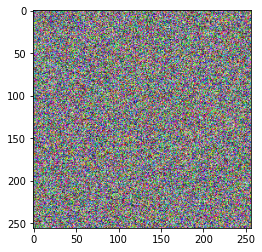

In [5]:
# Create a random colour "image" of shape 10x10 with a depth of 3 (for red, green and blue)
dummy_input = np.random.uniform(size=[256, 256, 3])
fig, ax = plt.subplots(1, 1)
plt.imshow(dummy_input)
ax.grid(False)
print('Input shape: {}'.format(dummy_input.shape))

Now adjust the hyperparameters using the sliders on the right and see how the output shape changes for a [256, 256, 3] input.

In [6]:
#@title Convolutional layer parameters {run: "auto"}
filters = 3  #@param { type: "slider", min:0, max: 10, step: 1 }
kernel_size = 2 #@param { type: "slider", min:1, max: 10, step: 1 }
stride = 1 #@param { type: "slider", min:1, max: 3, step: 1 }

conv_layer = tf.keras.layers.Conv2D(
    filters=filters,
    kernel_size=kernel_size,
    strides=stride,
    padding="valid",
    input_shape=[256, 256, 10])

# Convert the image to a tensor and add an extra batch dimension which
# the convolutional layer expects.
input_tensor = tf.convert_to_tensor(dummy_input[None, :, :, :])
convoluted = conv_layer(input_tensor)

print('The output dimension is: {}'.format(list(convoluted.shape)[1:]))
print('The number of parameters is: {}'.format(conv_layer.count_params()))

The output dimension is: [255, 255, 3]
The number of parameters is: 39


Note especially how output width and height are related to ```kernel_size``` and ```stride```, and how the output depth is related to ```filters```. You will also notice that once the `kernel_size>1` the height and width shrink. If you want to keep the same size you should pad the image (e.g. with zeros).

In the previous cell you also notice how easy it is to setup a convolutional layer in tensorflow by using `tf.keras.layers.Conv2D`. Now check the correspoding [help-page](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and see how you can add zero-padding and how it influences the output shape.


In [7]:
?tf.keras.layers.Conv2D

---

##### Self assessment


How many parameters would there be in a convolutional network with 2 convolutional layers consisting of a 3x3 kernel_size, 56 filters, a stride of 1 and zero-padding for an input image of shape [224, 224, 3] and a fully connected output size of 10? First try to visualize and calculate this by hand. Subsequently you can check that by coding it (see later self-assessment)


---

#### Building up complex filters

One of the reasons that CNNs have been so successful is their ability to build up complex filters by composing more simple filters. For example, imagine a 5 layer CNN that has been trained to detect faces. The first 4 layers are convolutional and the last layer is fully-connected and outputs the final prediction (is there a face or not). We might find that the filters in each convolution layer pick out the following features:

1. lines (horizontal, vertical, diagonal), and colour gradients,
2. corners, circles and other simple shapes, and simple textures,
3. noses, mouths, and eyes,
4. whole faces.

The neural net has learned to pick out complex objects like facial features and even whole faces! The reason for this is that each successive layer can combine the filters from the previous layer to detect more and more sophisticated features. The following diagram (adapted from [this paper](http://web.eecs.umich.edu/~honglak/icml09-ConvolutionalDeepBeliefNetworks.pdf)) shows some really cool examples of this kind of behaviour. The lower level features (shown above) detect noses, eyes, and mouths, in the case of faces, and wheels, doors, and windows, for cars. The higher level features are then able to detect whole faces and cars.

![Imgur](https://i.imgur.com/653uIty.jpg)

The diagrams on page 7 of [this classic paper](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf) show more examples of this phenomena and are definitely worth checking out!

### (Max) Pooling
A pooling layer reduces the spatial size of the representation. There are different reasons why we may want to do this. One is to reduce the number of parameters in the network. Imagine a convnet for a dataset with 10 classes. If the feature tensor produced by the final conv / pool / relu layer was say, of size 20x20 and had 100 feature channels, the final dense layer would have 20x20x100x10=400k parameters. However, if we down-sampled that layer to a 4x4 spatial size, we would have only 16k parameters. A big difference!

Another reason is that we want later features (deeper in the network) to have larger *receptive fields* (input regions that they look at), in order to represent bigger objects and object parts for instance. In particular, pooling stride gives later features much larger receptive fields so that they can effectively combine smaller features together.

A pooling layer has no trainable parameters. It applies some 2-D aggregation operation (usually a max(), but others like average() may also be used) to regions of the input volume. This is done independently for each depth dimension of the input. For example, a 2x2 max pooling operation with a stride of 2, downsamples every depth slice of the input by 2 along both the width and height.

The hyper-parameters of a pooling layer are as follows:
* **Pool Size** defines how many values are aggregated together.
* **Stride** defines the number of pixels by which we move the pooling filter when sliding it along the input. Typically this value would be equal to the pool size.
* **Padding** refers to the addition of 0-value pixels to the edges of the input volume along the width and height dimensions. In Tensorflow you can set this to "VALID", which essentially does no padding or "SAME" which pads the input such that the output width and height are the same as the input.





---


#### Self Assessment 
Do 2x2 max-pooling by hand, with a stride of 2, and "VALID" padding, on the following 2D input. What is the size of the output?*

\begin{bmatrix}
  9 & 5 & 4 & 5 & 6 & 4 \\
  6 & 6 & 3 & 5 & 8 & 2 \\
  4 & 6 & 9 & 1 & 3 & 6 \\
  9 & 7 & 1 & 5 & 8 & 1 \\
  4 & 9 & 9 & 5 & 7 & 3 \\
  7 & 3 & 6 & 4 & 9 & 1 
\end{bmatrix}

---



### Receptive fields

Earlier we mentioned that one reason to do pooling is to increase the sizes of the receptive fields of our features. Let's take a closer look at what we meant by this. The diagram below shows the effective receptive field of one output "neuron" in each layer of a few simple networks. What the diagram tells us is how many of the input values have an effect on each output value.

We can see that in the first two examples, with single convolutional layers, the receptive field is simply equal to the kernel size. 

However, the next two examples are a little more interesting. Here we have drastically increased the receptive field size, without a large increase in the number of parameters, by stacking convolution and pooling layers. The interesting thing here is that by using a pooling layer we increased our receptive field size by a much smaller cost (in the number of parameters) than if we'd simply increased the kernel sizes of our convolution layers.

You can read more about receptive fields [here](https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807).


![Receptive Fields](https://i.imgur.com/TjxEsG4.png)



---


#### Self Assessment 
 * Calculate the numbers of parameters that you would need to train for each of the 4 examples shown in the previous figure. 
 * Rank them in terms of computational cost (i.e. the number of parameters to train) and receptive fields. 
 * Discuss the (dis-)advantages of each approach.

---

# Part 2: Building a CNN for classification


## Loading a dataset
Now that we understand convolutional, max-pooling and feed-forward layers, we can combine these as building blocks to build a ConvNet classifier for images. With tensorflow you have direct access to a large set of available datasets for experimenting, benchmarking etc. To get an overview, check the corresponding [webpage](https://www.tensorflow.org/datasets/catalog/overview#all_datasets) and example [Colab notebook regarding datasets](https://)

For this practical, we will use the colour image dataset CIFAR10 (pronounced "seefar ten") which consists of 50,000 training images and 10,000 test images. We will take 10,000 images from the training set to form a validation set and visualise some example images.

In [10]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
# Take the last 10000 images from the training set to form a validation set
train_labels = train_labels.squeeze()
validation_images = train_images[-10000:, :, :]
validation_labels = train_labels[-10000:]
train_images = train_images[:-10000, :, :]
train_labels = train_labels[:-10000]

### Visualise examples from the dataset
Whenever doing a ML classification, it is always wise and therefore best-practice to get first some understanding of the data and how they look like (e.g., dimensions, visual appearance, label, ....). Therefore, you can use standard python packages to plot them with their corresponding label etc. In the following lines we do that. Run the cell below multiple times to see various images. (They might look a bit blurry because we've blown up the small images.)

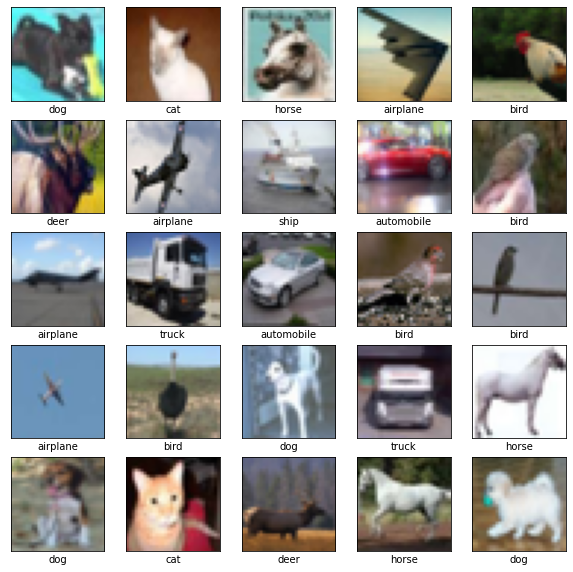

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  img_index = np.random.randint(0, 40000)
  plt.imshow(train_images[img_index])
  plt.xlabel(cifar_labels[train_labels[img_index]])

In [ ]:
print('train_images.shape = {}, data-type = {}'.format(train_images.shape, train_images.dtype))
print('train_labels.shape = {}, data-type = {}'.format(train_labels.shape, train_labels.dtype))

print('validation_images.shape = {}, data-type = {}'.format(validation_images.shape, validation_images.dtype))
print('validation_labels.shape = {}, data-type = {}'.format(validation_labels.shape, validation_labels.dtype))

train_images.shape = (40000, 32, 32, 3), data-type = uint8
train_labels.shape = (40000,), data-type = uint8
validation_images.shape = (10000, 32, 32, 3), data-type = uint8
validation_labels.shape = (10000,), data-type = uint8


Based on the data exploration we see that the images are `32x32x3` in size.

## A ConvNet Classifier
Finally, we build a simple convolutional architecture to classify the CIFAR images. We will build a mini version of the AlexNet architecture, which consists of 5 convolutional layers with max-pooling, followed by 3 fully-connected layers at the end. In order to investigate the effect each of these two layers has on the number of parameters, we'll build the model in two stages. 

First, the convolutional layers + max-pooling:

In [ ]:
# Define the convolutinal part of the model architecture using Keras Layers in a sequential model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
model.add(tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'))
model.add(tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))

As you can see in the previous block it is rather straightforward to build Tensorflow Keras Sequential model, where we first initialize the model and subsequently add layers that interact which each other sequentially. If we want to better understand the architecture, we can easily inspect this using the model summary function in Keras:


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       55424     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 192)         221376    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 192)         331968    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         2

Now we add a fully-connected part. Note that we also add "Dropout" after the first fully-connected layer. Dropout is a regularization technique which randomly zeros out ("drops") connections between neurons, and it was one of the key innovations of the AlexNet paper in 2012.

In [ ]:
model.add(tf.keras.layers.Flatten())  # Flatten "squeezes" a 3-D volume down into a single vector.
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       55424     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 192)         221376    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 192)         331968    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         2

----
##### Self assessment

*   Write a `tf.keras.models.Sequential()` model that corresponds to the FC and CNN self assessment questions of Step 1 and print their summary.
*   Check if the number of trainable parameters corresponds to your manual calculations.

----

Once we have defined the CNN model layers, we can initialize it with defining:



*   the **batch size**: number of samples processed before the model is updated
*   the **number of epochs**: number of complete passes through the training dataset before the training stops
*   the **optimizer** 
*   the **loss function**: the quantity that a model should seek to minimize during training.
*   the **metric**: function that is used to judge the performance of your model. Metric functions are similar to loss functions, except that the results from evaluating a metric are not used when training the model. 

In [ ]:
batch_size = 128 # number of samples processed before the model is updated
num_epochs = 10  # number of complete passes through the training dataset before the training stops

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

### Fit the model to the training data

Now that the CNN is completely initialised, we can start training it with the fit function:

In [ ]:
# The fit function allows you to fit the compiled model to some training data
history = model.fit(x=train_images,
          y=train_labels,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(validation_images, validation_labels.astype(np.float32)))
print('Training complete')

Epoch 1/10
313/313 [==============================] - 3s 9ms/step - loss: 1.7728 - accuracy: 0.3740 - val_loss: 1.3857 - val_accuracy: 0.5015
Epoch 2/10
313/313 [==============================] - 2s 8ms/step - loss: 1.2531 - accuracy: 0.5573 - val_loss: 1.1411 - val_accuracy: 0.5995
Epoch 3/10
313/313 [==============================] - 2s 8ms/step - loss: 1.0767 - accuracy: 0.6273 - val_loss: 1.0650 - val_accuracy: 0.6344
Epoch 4/10
313/313 [==============================] - 2s 8ms/step - loss: 0.9685 - accuracy: 0.6672 - val_loss: 1.0631 - val_accuracy: 0.6241
Epoch 5/10
313/313 [==============================] - 2s 8ms/step - loss: 0.8837 - accuracy: 0.6937 - val_loss: 1.0705 - val_accuracy: 0.6403
Epoch 6/10
313/313 [==============================] - 3s 8ms/step - loss: 0.8043 - accuracy: 0.7208 - val_loss: 0.9260 - val_accuracy: 0.6814
Epoch 7/10
313/313 [==============================] - 2s 8ms/step - loss: 0.7375 - accuracy: 0.7458 - val_loss: 0.9412 - val_accuracy: 0.6827
Epoch 

Potentially you can finetune the setup of your `model.fit` further: e.g. define `steps_per_epoch`, call a callback function to load tensorboard to visualize performance etc., but therefore I recommend to check the `.fit()` [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and the [TensorBoard manual](https://www.tensorflow.org/tensorboard/get_started) if you want to use TensorBoard visualisation tool.

### Assess and visualize performance

The fit function already print some of it's output to the screen, but we can also access this information if we write it to a variable (e.g., `history `in previous block). In the following block we can for example plot the loss and accuracy of the model fit for each epoch.

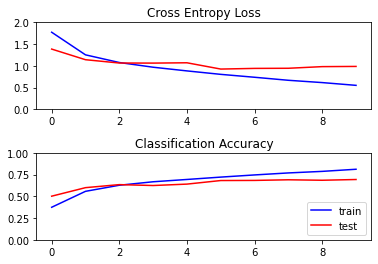

In [ ]:
# plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='test')
plt.ylim(0,2)
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='test')
plt.ylim(0,1)
# add legend
plt.legend()
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.5)

### Test performance
Finally, we evaluate how well the model does on the held-out test-set

In [ ]:
metric_values = model.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

313/313 [==============================] - 1s 2ms/step - loss: 1.0051 - accuracy: 0.6868
Final TEST performance
loss: 1.005070447921753
accuracy: 0.6868000030517578


Note that we achieved roughly 80% training set accuracy, but our test accuracy is only around 67%. What do you think may be the reason for this?

### Classifying examples
We now use our trained model to classify a sample of 25 images from the test set. We pass these 25 images to the  ```model.predict``` function, which returns a [25, 10] dimensional matrix. The entry at position $(i, j)$ of this matrix contains the probability that image $i$ belongs to class $j$. We obtain the most-likely prediction using the ```np.argmax``` function which returns the index of the maximum entry along the columns. Finally, we plot the result with the prediction and prediction probability labelled underneath the image and true label on the side. 

In [ ]:
img_indices = np.random.randint(0, len(test_images), size=[25])
sample_test_images = test_images[img_indices]
sample_test_labels = [cifar_labels[i] for i in test_labels[img_indices].squeeze()]

predictions = model.predict(sample_test_images)
max_prediction = np.argmax(predictions, axis=1)
prediction_probs = np.max(predictions, axis=1)

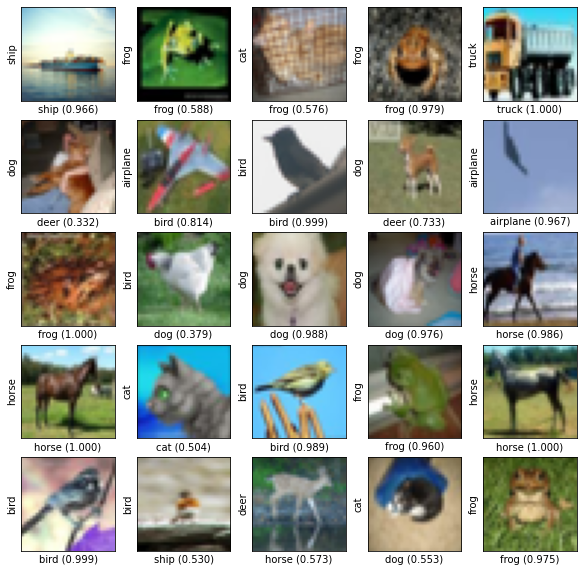

In [ ]:
plt.figure(figsize=(10,10))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction, prediction_probs, sample_test_labels)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  plt.imshow(img)
  plt.xlabel('{} ({:0.3f})'.format(cifar_labels[prediction], prob))
  plt.ylabel('{}'.format(true_label))




---

### Self assessment
 What do you think of the model's predictions? Looking at the model's confidence (the probability assigned to the predicted class), look for examples of the following cases:
1. The model was correct with high confidence
2. The model was correct with low confidence
3. The model was incorrect with high confidence
4. The model was incorrect with low confidence

What do you think the (relative) loss values would be in those cases?


---



---
### Self assessment
 * Experiment with the network architecture we just built: try changing the numbers, types and sizes of layers, the sizes of filters, using different padding etc. 

 * Explain and show how these decisions affect architecture and the performance of the model? Illustrate this by plotting loss and accuracy for training and testing for your different models. 

* In particular, try building a *fully convolutinal* network, with no (max-)pooling layers. 
---- 

--- 
### Self assessment
 * Add DROPOUT ([Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)) and BATCH NORMALISATION ([Tensorflow documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/BatchNormalization) to improve the model's generalisation. You can do this by adding `model.add(tf.keras.layers.Dropout())` and `tf.keras.layers.BatchNormalization()` layers to your sequential model.

 * What is the effect of the generalization efforts on the performance of the model? Illustrate this by plotting loss and accuracy for training and testing for your different models.

 * Based on your experiments so far, build a model that has >80% accuracy on the test set and illustrate its performance.
 --- 

## Learn from existing CNN architectures

Deciding on the architecture for a CNN, i.e. the combination of convolution, pooling, dense, and other layers, can be tricky and often can seem arbitrary. On top of that, one also has to make decisions such as what kind of pooling, which activation functions, and what size of convolution to use, among other things. For new and old practitioners of deep learning, these choices can be overwhelming. 

However, by examining existing successful CNN architectures we can learn a lot about what works and what doesn't. (We can even apply these existing architectures to our problems since many deep learning libraries, such as TensorFlow and Keras, have them [built in](https://keras.io/applications/#available-models) and it is even possible to fine-tune pre-trained models to our specific problem using [transfer learning](https://cs231n.github.io/transfer-learning/).)

[This article](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5) describes many of the most successful CNN architectures in recent years, including [ResNet](https://arxiv.org/abs/1512.03385), [Inception](https://arxiv.org/pdf/1512.00567v3.pdf) and [VGG](https://arxiv.org/pdf/1409.1556.pdf). For a more detailed and technical description of these models and more see [these slides](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture9.pdf). Reading through these resources should give you insights into why these architectures are successful as well as best practices and current trends for CNNs that will help you design your own architectures.

For example, one of the practices you might pick up on is the use of 3x3 convolutions. You'll notices that older architectures such as [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) used a range of convolutions from 7x7 down to 3x3. However, newer architectures such as VGG and ResNet use 3x3 convolutions almost exclusively. In short, the reason is that stacking 3x3 convolutions gives you the same receptive field as a larger convolution but with more non-linearity. 


You can load the existing architectures from the https://keras.io/api/applications:

In [3]:
model = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model.summary()

574726144/574710816 [==============================] - 6s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________


---
### Self assessment 
Here are some other questions you may want to think about while investigating these architectures:

* Why do modern architectures use less max-pooling?
* What does a 1x1 convolution do?
---

# Part 3: Transfer learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets. A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded (as you just did for VGG19) and used directly, or integrated into a new model for your own computer vision problems. This is what we call **Transfer learning**. 

Transfer learning has the benefit of decreasing the training time for a neural network model and can result in lower generalization error. The weights in re-used layers may be used as the starting point for the training process and adapted in response to the new problem. This usage treats transfer learning as a type of weight initialization scheme. This may be useful when the first related problem has a lot more labeled data than the problem of interest and the similarity in the structure of the problem may be useful in both contexts.

The use of a pre-trained model is limited only by your creativity.

For example, a model may be downloaded and used as-is, such as embedded into an application and used to classify new photographs.

Alternately, models may be downloaded and use as feature extraction models. Here, the output of the model from a layer prior to the output layer of the model is used as input to a new classifier model.

Recall that convolutional layers closer to the input layer of the model learn low-level features such as lines, that layers in the middle of the layer learn complex abstract features that combine the lower level features extracted from the input, and layers closer to the output interpret the extracted features in the context of a classification task.

Armed with this understanding, a level of detail for feature extraction from an existing pre-trained model can be chosen. For example, if a new task is quite different from classifying objects in photographs (e.g. different to ImageNet), then perhaps the output of the pre-trained model after the few layers would be appropriate. If a new task is quite similar to the task of classifying objects in photographs, then perhaps the output from layers much deeper in the model can be used, or even the output of the fully connected layer prior to the output layer can be used.

The pre-trained model can be used as a separate feature extraction program, in which case input can be pre-processed by the model or portion of the model to a given an output (e.g. vector of numbers) for each input image, that can then use as input when training a new model.

Alternately, the pre-trained model or desired portion of the model can be integrated directly into a new neural network model. In this usage, the weights of the pre-trained can be frozen so that they are not updated as the new model is trained. Alternately, the weights may be updated during the training of the new model, perhaps with a lower learning rate, allowing the pre-trained model to act like a weight initialization scheme when training the new model.

We can summarize some of these usage patterns as follows:

 * Classifier: The pre-trained model is used directly to classify new images.
 * Standalone Feature Extractor: The pre-trained model, or some portion of the model, is used to pre-process images and extract relevant features.
 * Integrated Feature Extractor: The pre-trained model, or some portion of the model, is integrated into a new model, but layers of the pre-trained model are frozen during training.
 * Weight Initialization: The pre-trained model, or some portion of the model, is integrated into a new model, and the layers of the pre-trained model are trained in concert with the new model.
Each approach can be effective and save significant time in developing and training a deep convolutional neural network model.

It may not be clear as to which usage of the pre-trained model may yield the best results on your new computer vision task, therefore some experimentation may be required.

#### Transfer learning in tensorflow
The first time a pre-trained model is loaded, tf.feras will download the required model weights, which may take some time given the speed of your internet connection. Weights are stored in the .keras/models/ directory under your home directory and will be loaded from this location the next time that they are used.

When loading a given model, the `include_top` argument can be set to False, in which case the fully-connected output layers of the model used to make predictions is not loaded, allowing a new output layer to be added and trained. Additionally, when the “include_top” argument is False, the `input_tensor` argument must be specified, allowing the expected fixed-sized input of the model to be changed. For example:

In [5]:
# load model and specify a new input shape for images
new_input = tf.keras.Input(shape=(640, 480, 3))
model = tf.keras.applications.VGG19(include_top=False, input_tensor=new_input)

80150528/80134624 [==============================] - 1s 0us/step


A model without a top will output activations from the last convolutional or pooling layer directly. One approach to summarizing these activations for thier use in a classifier or as a feature vector representation of input is to add a global pooling layer, such as a max global pooling or average global pooling. The result is a vector that can be used as a feature descriptor for an input. Keras provides this capability directly via the ‘pooling‘ argument that can be set to ‘avg‘ or ‘max‘. For example:

In [6]:
model = tf.keras.applications.VGG19(include_top=False, input_tensor=new_input, pooling='avg')

Images can be prepared for a given model using the preprocess_input() function; e.g., pixel scaling is performed in a way that was performed to images in the training dataset when the model was developed. For example:

In [11]:
prepared_images = tf.keras.applications.vgg19.preprocess_input(train_images[0])

Finally, you may wish to use a model architecture on your dataset, but not use the pre-trained weights, and instead initialize the model with random weights and train the model from scratch.

This can be achieved by setting the `weights` argument to None instead of the default ‘imagenet‘. Additionally, the `classes` argument can be set to define the number of classes in your dataset, which will then be configured for you in the output layer of the model. For example:

In [13]:
# model = tf.keras.applications.VGG19(weights=None, input_tensor=new_input, classes=10)

ResourceExhaustedError: ignored

Now that we are familiar with how to load pre-trained models in Keras, let’s look at some examples of how they might be used in practice. 

#### Standalone program

In these examples, we will work with the VGG16 model as a standalone program. VGG16 as it is a relatively straightforward model to use and a simple model architecture to understand. We also need a photograph to work with in these examples. [Download](https://machinelearningmastery.com/wp-content/uploads/2019/02/dog.jpg) the photograph and place it in your current working directory with the filename `dog.jpg`.

In [18]:
# example of using a pre-trained model as a classifier
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
# load an image from file
image = load_img('dog.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# load the model
model = VGG16()
model.summary()
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Running the example predicts more than just dog; it also predicts the specific breed of ‘Doberman‘ with a probability of ~35%, which may, in fact, be correct.
The last few layers of the loaded model are fully connected layers prior to the output layer. These layers will provide a complex set of features to describe a given input image and may provide useful input when training a new model for image classification or related computer vision task.


#### Feature extractor
Alternatively we can use some or all of the layers in a pre-trained model as a feature extraction component of a new model directly.

This can be achieved by loading the model, then simply adding new layers. This may involve adding new convolutional and pooling layers to expand upon the feature extraction capabilities of the model or adding new fully connected classifier type layers to learn how to interpret the extracted features on a new dataset, or some combination.

For example, we can load the VGG16 models without the classifier part of the model by specifying the “include_top” argument to “False”, and specify the preferred shape of the images in our new dataset as 300×300. We can then use the Keras function API to add a new Flatten layer after the last pooling layer in the VGG16 model, then define a new classifier model with a Dense fully connected layer and an output layer that will predict the probability for 10 classes. 



In [15]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(300, 300, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
______________________________________________________________

In the previous example, when we fit the model, the weights of the VGG16 model and the weights for the new model will all be trained together on the new dataset.

Alternately, we may wish to use the VGG16 model layers, but train the new layers of the model without updating the weights of the VGG16 layers. This will allow the new output layers to learn to interpret the learned features of the VGG16 model.

This can be achieved by setting the “trainable” property on each of the layers in the loaded model to False prior to training. For example:

In [16]:
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(300, 300, 3))
# mark loaded layers as not trainable
for layer in model.layers:
	layer.trainable = False

You can pick and choose which layers are trainable.

For example, perhaps you want to retrain some of the convolutional layers deep in the model, but none of the layers earlier in the model. For example:

In [17]:
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(300, 300, 3))
# mark some layers as not trainable
model.get_layer('block1_conv1').trainable = False
model.get_layer('block1_conv2').trainable = False
model.get_layer('block2_conv1').trainable = False
model.get_layer('block2_conv2').trainable = False

--- 
### Self assessment
* Compare the architecture of the standalone model and feature extractor model for (dis)similarities.
* What would be the effect on the classification for these different models?
* What effect do you expect when fixing the none/some/all weights on the training time and accuracy?
---

# Part 4: Visualizing what CNN's learn

Once we have built a model we can try to understand what the model has learnt by visualizing their outputs.

It is often said that deep learning models are "black boxes", learning representations that are difficult to extract and present in a 
human-readable form. While this is partially true for certain types of deep learning models, it is definitely not true for convnets. The 
representations learned by convnets are highly amenable to visualization, in large part because they are _representations of visual 
concepts_. Since 2013, a wide array of techniques have been developed for visualizing and interpreting these representations. Here we will use only one of the most accessible and useful ones as we will focus on visualizing intermediate convnet outputs ("intermediate activations"). This is useful to understand how successive convnet layers transform their input, and to get a first idea of the meaning of individual convnet filters.

We will use the small convnet that we trained in the previous section

## Visualizing intermediate activations

Visualizing intermediate activations consists in displaying the feature maps that are output by various convolution and pooling layers in a 
network, given a certain input (the output of a layer is often called its "activation", the output of the activation function). This gives 
a view into how an input is decomposed unto the different filters learned by the network. These feature maps we want to visualize have 3 
dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these 
feature maps is by independently plotting the contents of every channel, as a 2D image.

Now let's load a random test image

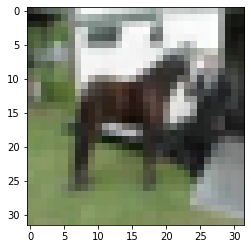

In [19]:
from keras.preprocessing import image

# Take a random test image (e.g. number 20) and convert it to an array
img_tensor = image.img_to_array(test_images[20])
# Expand the first dimension 
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

# Let's display our picture:
plt.imshow(img_tensor[0])

In order to extract the feature maps we want to look at, we will create a Keras model that takes batches of images as input, and outputs 
the activations of all convolution and pooling layers. To do this, we will use the Keras class `Model`. A `Model` is instantiated using two 
arguments: an input tensor (or list of input tensors), and an output tensor (or list of output tensors). The resulting class is a Keras 
model, just like the `Sequential` model that we used before, mapping the specified inputs to the specified outputs. What sets the 
`Model` class apart is that it allows for models with multiple outputs, unlike `Sequential`. 

In [22]:
from keras import models

# Define the convolutinal part of the model architecture using Keras Layers in a sequential model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
model.add(tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'))
model.add(tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:10]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the original model. This is from the sequential models that had exactly one input and one output. In the general case, a 
model could have any number of inputs and outputs. This one has one input and 8 outputs, one output per layer activation.

In [23]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

For instance, this is the activation of the first convolution layer for our test image input:

In [24]:
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 32, 32, 48)

It's a 32x32 feature map with 48 channels. Let's try visualizing the 3rd channel:

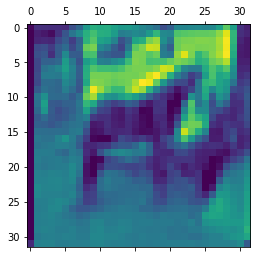

In [25]:
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

Let's try the another channel (30th) -- but note that your own channels may vary, since the specific filters learned by convolution layers are not deterministic.

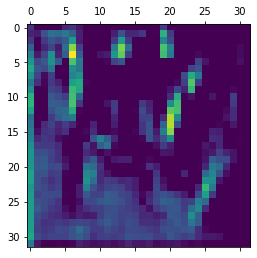

In [26]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

At this point, let's go and plot a complete visualization of all the activations in the network. We'll extract and plot every channel in each of our 8 activation maps, and we will stack the results in one big image tensor, with channels stacked side by side.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


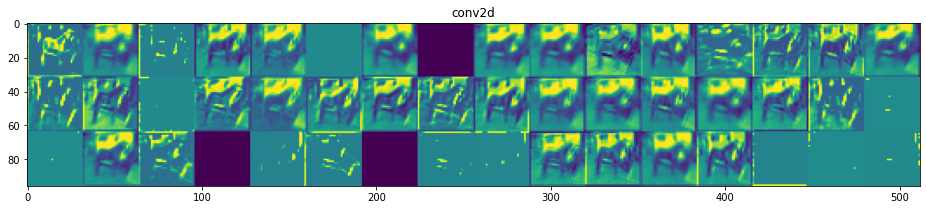

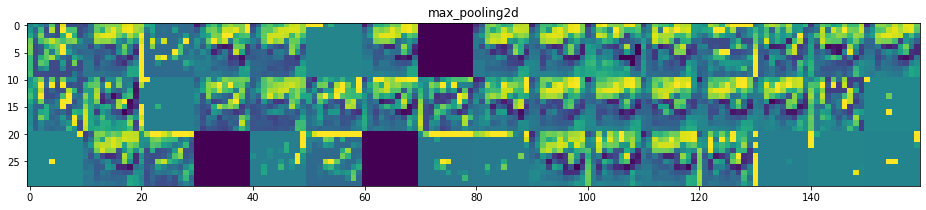

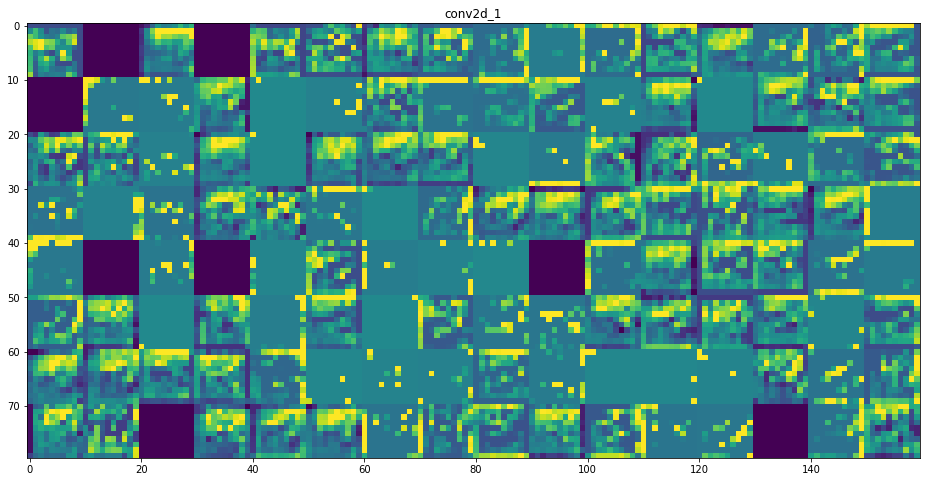

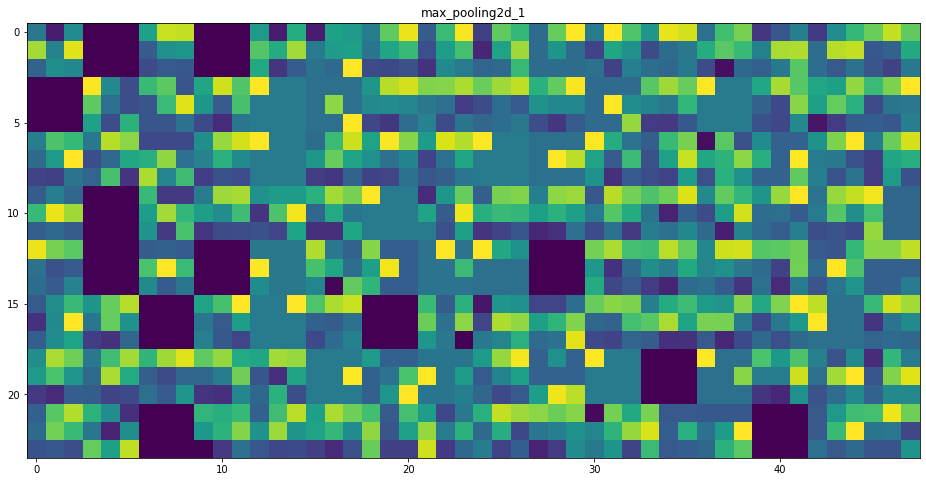

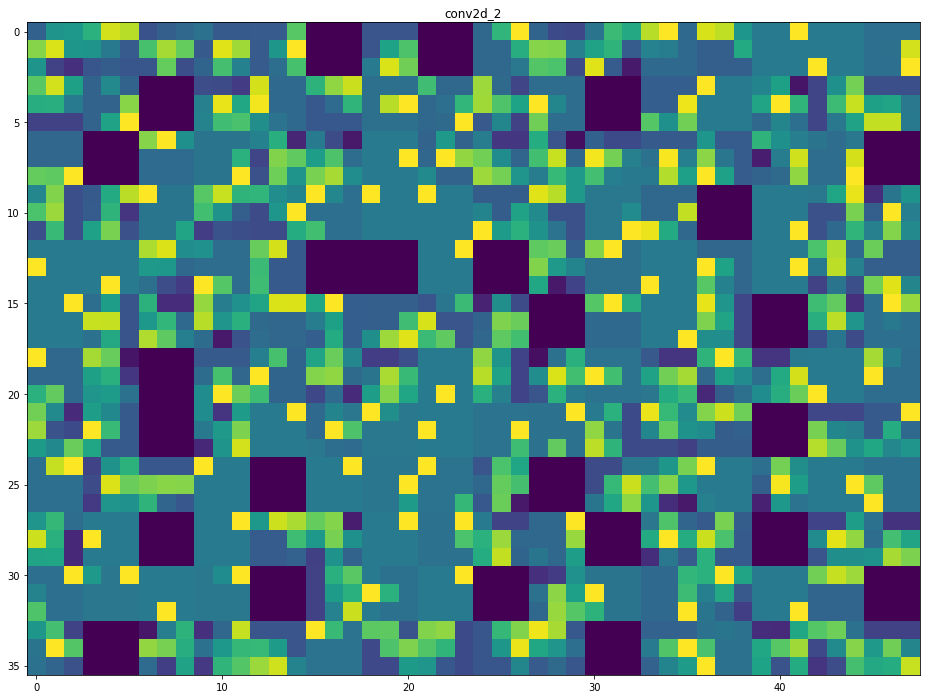

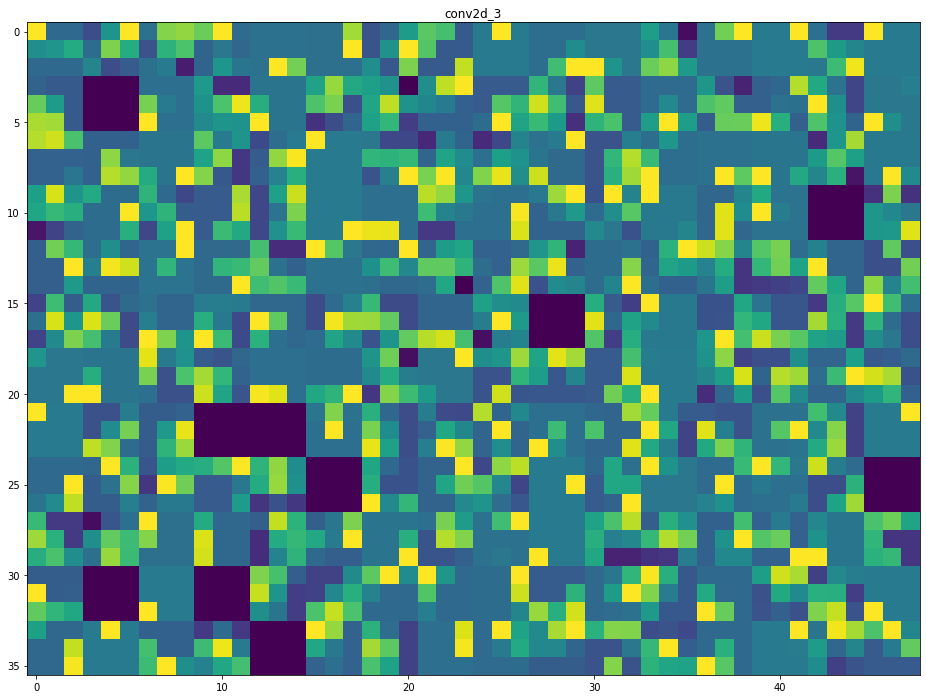

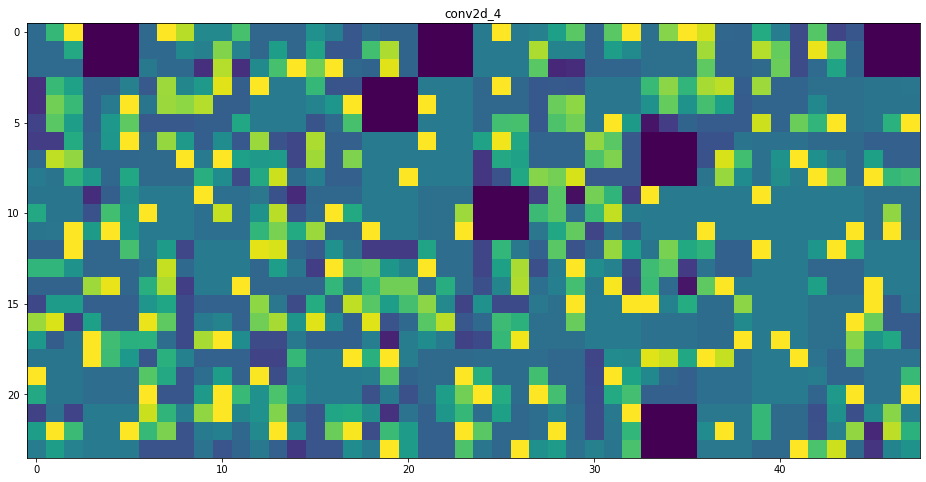

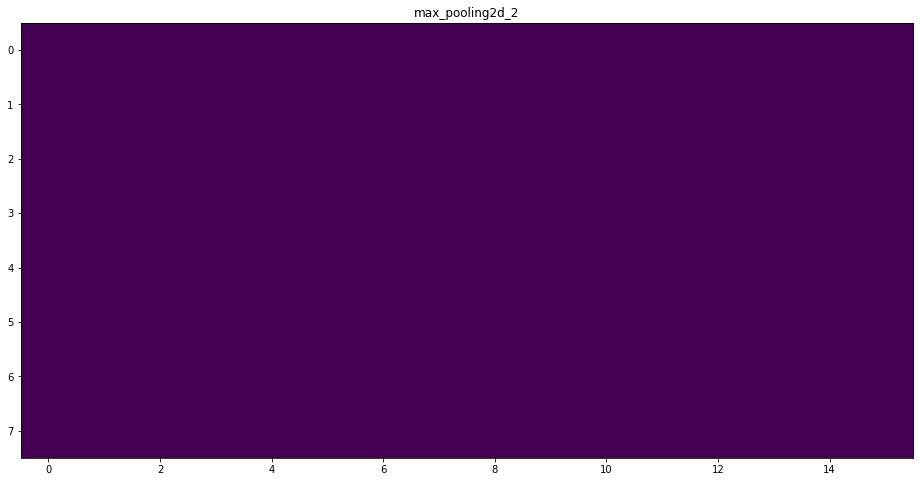

In [27]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

A few remarkable things to note here:

* The first layer acts as a collection of various edge detectors. At that stage, the activations are still retaining almost all of the 
information present in the initial picture.
* As we go higher-up, the activations become increasingly abstract and less visually interpretable. They start encoding higher-level 
concepts. Higher-up presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
* The sparsity of the activations is increasing with the depth of the layer: in the first layer, all filters are activated by the input image, but in the following layers more and more filters are blank. This means that the pattern encoded by the filter isn't found in the input image. 




We have just evidenced a very important universal characteristic of the representations learned by deep neural networks: the features 
extracted by a layer get increasingly abstract with the depth of the layer. The activations of layers higher-up carry less and less 
information about the specific input being seen, and more and more information about the target. A deep neural network effectively acts as an __information distillation pipeline__, with raw data going in (in our case, RBG 
pictures), and getting repeatedly transformed so that irrelevant information gets filtered out (e.g. the specific visual appearance of the 
image) while useful information get magnified and refined (e.g. the class of the image).

This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which 
abstract objects were present in it (e.g. bicycle, tree) but could not remember the specific appearance of these objects. In fact, if you 
tried to draw a generic bicycle from mind right now, chances are you could not get it even remotely right, even though you have seen 
thousands of bicycles in your lifetime. You brain has learned to completely abstract its visual input, to transform it into high-level visual concepts while completely filtering out irrelevant visual details, making it 
tremendously difficult to remember how things around us actually look.

---
## Self assessment
 * Take 2 different test images and show how the model visualize the intermediate activations. 
 * Can you their similarities and differences?
---


# Part 5: Classification and localisation
Now the previous examples we always worked with classification of an image, which means we get one output (class) for each image. We can however also modify them to become classification+localisation CNNs by learning them to output your bounding box coordinates.

Object localization is the task of locating an instance of a particular object category in an image, typically by specifying a tightly cropped bounding box centered on the instance. Object detection, on the contrary, is the task of locating all the possible instances of all the target objects.
Object localization is also called “classification with localization”. This is because the architecture which performs image classification can be slightly modified to predict the bounding box coordinates.



### Localisation data set

In the next steps we will show how it works by building an object localization model and train it on a synthetic dataset. We will use a synthetic dataset for our object localization task based on the MNIST dataset. The idea is that instead of 28x28 pixel MNIST images, it could be NxN(100x100), and the task is to predict the bounding box for the digit location. 

<img src="https://miro.medium.com/max/569/0*I2TprktWKDTjJD9Z.png" width="600" >


You can download the dataset from https://github.com/ayulockin/synthetic_datasets. We also have a .csv training and testing file with the name of the images, labels, and the bounding box coordinates. Note that the coordinates are scaled to [0, 1].

In [28]:
!git clone https://github.com/ayulockin/synthetic_datasets
%cd synthetic_datasets/MNIST/
%mkdir images
!unzip -q MNIST_Converted_Training.zip -d images/
!unzip -q MNIST_Converted_Testing.zip -d images/

Cloning into 'synthetic_datasets'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 42 (delta 14), reused 35 (delta 9), pack-reused 0
Unpacking objects: 100% (42/42), done.
/content/synthetic_datasets/MNIST


### Data preprocessing

We will use `tf.data.Dataset` to build our input pipeline. Our model will have to predict the class of the image(object in question) and the bounding box coordinates given an input image. This is fundamentally different from our earlier classifiers as it a **multi-output architecture** where we will return a dictionary of labels and bounding box coordinates along with the image.

First we need to prepare dataset for input to get both the class labels and the bbox coordinates:

In [32]:
TRAIN_IMG_PATH = 'images/MNIST_Converted_Training/'
TEST_IMG_PATH = 'images/MNIST_Converted_Testing/'

In [35]:
train_df = pd.read_csv('training_data.csv', header=None)
test_df = pd.read_csv('test_data.csv', header=None)

columns = ['img_name', 'label', 'x1', 'y1', 'x2', 'y2']
train_df.columns = columns
test_df.columns = columns

train_df.head()

,img_name,label,x1,y1,x2,y2
0,converted_training1.png,4,0.49,0.15,0.77,0.43
1,converted_training2.png,1,0.64,0.26,0.92,0.54
2,converted_training3.png,0,0.42,0.39,0.70,0.67
3,converted_training4.png,7,0.58,0.10,0.86,0.38
4,converted_training5.png,8,0.21,0.23,0.49,0.51


In [36]:
train_image_names = train_df.img_name.values
train_labels = train_df.label.values
train_bbox = train_df[['x1', 'y1', 'x2', 'y2']].values

test_image_names = test_df.img_name.values
test_labels = test_df.label.values
test_bbox = test_df[['x1', 'y1', 'x2', 'y2']].values

The we need to load the data into tensorflow:

In [37]:

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
@tf.function
def preprocess_train(image_name, label, bbox):
    image = tf.io.read_file(TRAIN_IMG_PATH+image_name)
    image = tf.image.decode_png(image, channels=1)
    return image, {'label': label, 'bbox': bbox} # Notice here
@tf.function
def preprocess_test(image_name, label, bbox):
    image = tf.io.read_file(TEST_IMG_PATH+image_name)
    image = tf.image.decode_png(image, channels=1)
    return image, {'label': label, 'bbox': bbox} # Notice here
trainloader = tf.data.Dataset.from_tensor_slices((train_image_names, train_labels, train_bbox))
testloader = tf.data.Dataset.from_tensor_slices((test_image_names, test_labels, test_bbox))
trainloader = (
    trainloader
    .map(preprocess_train, num_parallel_calls=AUTO)
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
testloader = (
    testloader
    .map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

We can visualize it with our own function:

In [38]:
# Ref: https://www.tensorflow.org/tutorials/load_data/images
def show_batch(image_batch, label_batch, bbox):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      img = np.squeeze(image_batch[n], axis=-1)
      img = cv2.rectangle(img,(bbox[n][0],bbox[n][1]),(bbox[n][2],bbox[n][3]),(255,0,0),2)
      plt.imshow(img, cmap='gray')
      plt.title(label_batch[n])
      plt.axis('off')

In [40]:
img_samples, label_bbox = next(iter(trainloader))
img_samples.shape, label_bbox['label'].shape, label_bbox['bbox'].shape

(TensorShape([32, 100, 100, 1]), TensorShape([32]), TensorShape([32, 4]))

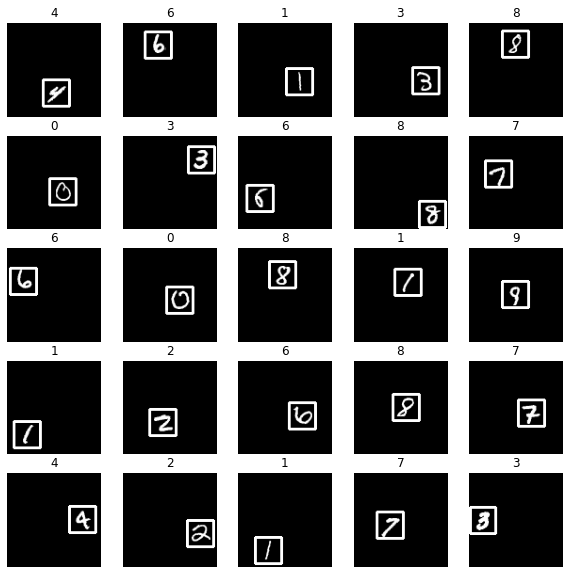

In [41]:
show_batch(img_samples, label_bbox['label'].numpy(), (label_bbox['bbox'].numpy()*100).astype('int32'))

### Localisation = 2-head problem
Before we build our model, let’s briefly discuss bounding box regression. In machine learning literature regression is a task to map the input value X with the continuous output variable y. Thus we return a number instead of a class, and in our case, we’re going to return 4 numbers (x1, y1, x2, y2) that are related to a bounding box. We will train this system with an image and a ground truth bounding box, and use L2 loss to calculate the loss between the predicted bounding box and the ground truth. 


<img src="https://miro.medium.com/max/700/0*-7pdw0pSFbwNJmpL.png" width="600">



As can be seen in the above figure, the model constitutes three components:
* convolutional block(feature extractor)
* classification head
* regression head.

This is a multi-output configuration. As mentioned in the dataset section, the `tf.data.Dataset` input pipeline returns a dictionary, whose key names are the name of the output layer of the classification head and the regression head.
The code snippet shown below builds our model architecture for object localization.


In [46]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

In [47]:
def get_model():
    inputs = Input(shape=(100,100,1))
    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D((3,3))(x)
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = MaxPooling2D((3,3))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    classifier_head = Dropout(0.3)(x)
    classifier_head = Dense(10, activation='softmax', name='label')(classifier_head)

    reg_head = Dense(64, activation='relu')(x)
    reg_head = Dense(32, activation='relu')(reg_head)
    reg_head = Dense(4, activation='sigmoid', name='bbox')(reg_head)

    return Model(inputs=[inputs], outputs=[classifier_head, reg_head])

As you can see in the code, the model starts two branches after the convolution and pooling:
* `classifier_head = Dropout(0.3)(x)`
* `reg_head = Dense(64, activation='relu')(x)`

and also has two outputs.


In [48]:
model = get_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 98, 98, 32)   320         input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 30, 30, 32)   9248        max_pooling2d_3[0][0]            
____________________________________________________________________________________________

You can also visualize this  using one tensorflow.keras.utils funcions:

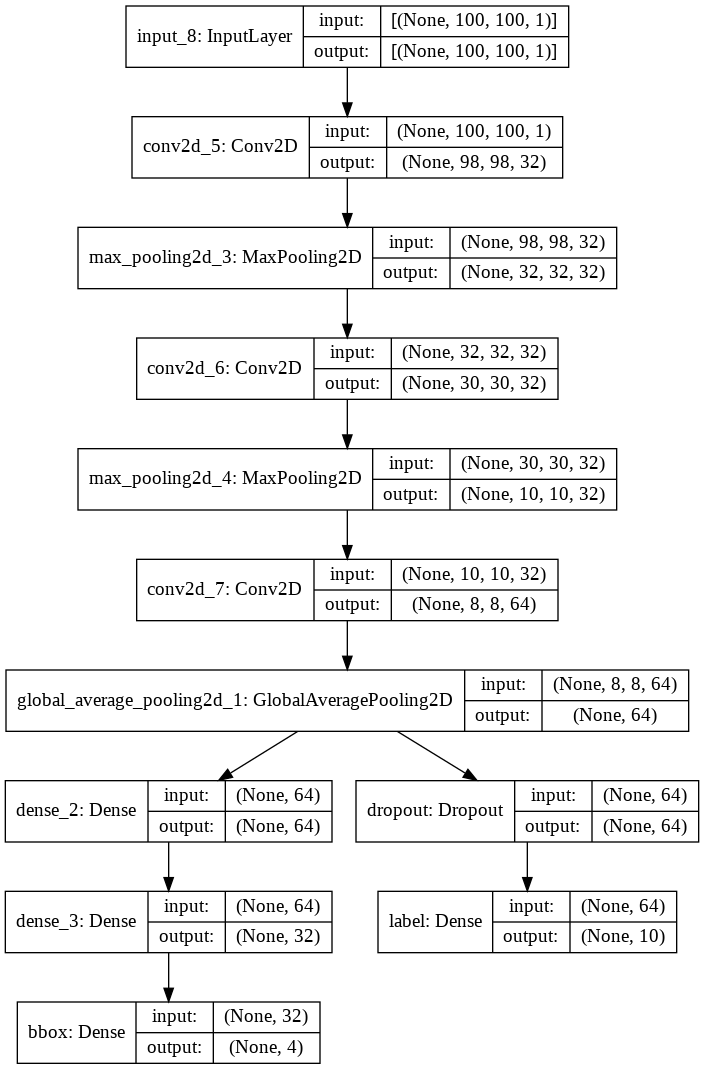

In [49]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)

Subsequentlty we need to define the losses for both heads. The `name` given to the multiple heads are used as keys for the losses dictionary. Note that the activation function for the classification head is softmax since it's a multi-class classification setup(0-9 digits). The activation function for the regression head is sigmoid since the bounding box coordinates are in the range of [0, 1]. We can optionally give different weightage to different loss functions.

In [51]:
losses = {'label': 'sparse_categorical_crossentropy',
          'bbox': 'mse'}

loss_weights = {'label': 1.0,
                'bbox': 1.0}

Then we can compile and fit the model:

In [52]:
model.compile('adam', loss=losses, loss_weights=loss_weights, metrics=['acc'])

In [55]:
model.fit(trainloader,
          epochs=3,
          validation_data=testloader,)

Epoch 1/3
1875/1875 [==============================] - 39s 20ms/step - loss: 0.1025 - label_loss: 0.0962 - bbox_loss: 0.0064 - label_acc: 0.9708 - bbox_acc: 0.8770 - val_loss: 0.0691 - val_label_loss: 0.0632 - val_bbox_loss: 0.0059 - val_label_acc: 0.9813 - val_bbox_acc: 0.8853
Epoch 2/3
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0877 - label_loss: 0.0820 - bbox_loss: 0.0057 - label_acc: 0.9751 - bbox_acc: 0.8806 - val_loss: 0.0567 - val_label_loss: 0.0512 - val_bbox_loss: 0.0054 - val_label_acc: 0.9838 - val_bbox_acc: 0.8805
Epoch 3/3
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0783 - label_loss: 0.0731 - bbox_loss: 0.0051 - label_acc: 0.9786 - bbox_acc: 0.8834 - val_loss: 0.0597 - val_label_loss: 0.0547 - val_bbox_loss: 0.0049 - val_label_acc: 0.9828 - val_bbox_acc: 0.8804


Based on this model we can now predict both the label and the bounding box:

In [56]:
pred = model.predict(testloader)
pred

You could try to visualize this yourself.

# Part 6: U-Net's

After doing classification and classification+localisation, we are nog going to the final step of instance segmentation (as we don't cover multiple object detection in this course). Therefore we are going to work with U-nets, which do not provide a single output (as in classification) or multiple outputs (label+bbox in classification+localisation), but return an image of the same size as the input.

## Loading data
First, we start by loading the training data set, which consist of 999 images of 256x256 pixels and 3 channels (R,G,B) and their corresponding road mask. This road mask has been obtained by thresholding the Google Maps background that corresponds to the satellite image. In this thresholding step all white pixels in the Google Maps background are converted to a road masks.

```
# This is formatted as code
```

 

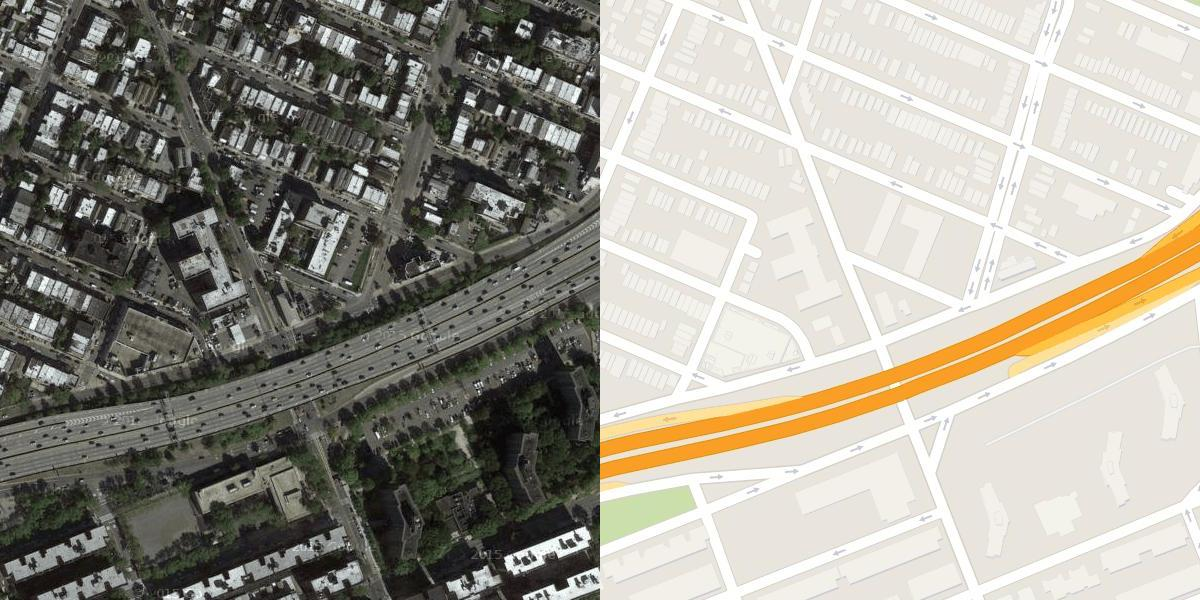

In [ ]:
# Load the compressed training data set
file = h5py.File('Dataset_train.h5', 'r')
# Get the images
imgs_train = file.get('images')
# Get the road labels
imgs_mask_train = file.get('masks')
imgs_train = np.array(imgs_train)
imgs_mask_train = np.array(imgs_mask_train)

imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train /= 255  # scale masks to [0, 1]

Now let's plot a random image and corresponding mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

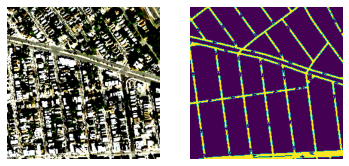

In [ ]:
plt.subplot(121)
plt.imshow(imgs_train[5,:,:,:])
plt.axis('off')
plt.subplot(122)
plt.imshow(imgs_mask_train[5,:,:,0])
plt.axis('off')

## The U-Net classifier

Before using the U-Net, we first need to define its architecture, which follows a similar approach as the earlier CNN's but now includes the upsampling layers. To do so, we do not use a Sequential model, but build our own model, where each of the layers uses the input of the previous layer

In [ ]:
# Load the necessary packages
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
from keras import backend as keras

### Define the U-Net architecture

In [ ]:
# Define the U-Net model
def unet(input_size = (256, 256, 3)):
    inputs = Input(input_size)

    # Convulution 1
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(inputs)

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(conv1)
    
    # Pooling 1
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Convolution 2
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv2)
    
    # Pooling 2
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Convolution 3
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv3)
    # Pooling 3
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Convolution 3
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv4)
    # Dropout
    drop4 = Dropout(0.5)(conv4)
    
    # Pooling 4
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Convolution 5
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(pool4)
    
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(conv5)
    # Dropout
    drop5 = Dropout(0.5)(conv5)

    # Upward Convolution 6
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', 
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(drop5))
    
    # Here we copy the input from the upward convolution and contraction path
    merge6 = concatenate([drop4,up6])
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge6)
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv6)

    # Upward Convolution 7
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv6))
    
    # Here we copy the input from the upward convolution and contraction path
    merge7 = concatenate([conv3,up7])
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge7)
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'
                                                )(conv7)

    # Upward Convolution 8
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv7))
    
    # Here we copy the input from the upward convolution and contraction path
    merge8 = concatenate([conv2,up8])
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge8)
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv8)
    # Upward Convolution 9
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',
                                             kernel_initializer = 'he_normal'
                                             )(UpSampling2D(size = (2,2))(conv8))
    
    # Here we copy the input from the upward convolution and contraction path
    merge9 = concatenate([conv1,up9])
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(merge9)
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv9)
    
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(conv9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
# Initiate the U-Net model
model = unet()

# Show the model architecture
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_7[0][0]                   
_______________________________________________________________________________________

Now let's define a checkpoint function that allows us to save the weights

In [ ]:
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

### Fit the U-Net model
Fit the model to the training data. Notice that this is again very similar to the CNN's, we only do not use the fixed validation_data, but use the validation_split (i.e., Fraction of the training data to be used as validation data).

In [ ]:
history =  model.fit(imgs_train, imgs_mask_train, batch_size=32, epochs=20, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint])

Epoch 1/20
25/25 [==============================] - 64s 3s/step - loss: 337.9658 - accuracy: 0.9217 - val_loss: 0.2542 - val_accuracy: 0.9234
Epoch 2/20
25/25 [==============================] - 52s 2s/step - loss: 0.2496 - accuracy: 0.9223 - val_loss: 0.2351 - val_accuracy: 0.9233
Epoch 3/20
25/25 [==============================] - 51s 2s/step - loss: 0.2352 - accuracy: 0.9222 - val_loss: 0.2250 - val_accuracy: 0.9233
Epoch 4/20
25/25 [==============================] - 54s 2s/step - loss: 0.2271 - accuracy: 0.9226 - val_loss: 0.2188 - val_accuracy: 0.9240
Epoch 5/20
25/25 [==============================] - 52s 2s/step - loss: 0.2263 - accuracy: 0.9227 - val_loss: 0.2174 - val_accuracy: 0.9238
Epoch 6/20
25/25 [==============================] - 53s 2s/step - loss: 0.2198 - accuracy: 0.9232 - val_loss: 0.2126 - val_accuracy: 0.9243
Epoch 7/20
25/25 [==============================] - 52s 2s/step - loss: 0.2136 - accuracy: 0.9239 - val_loss: 0.2101 - val_accuracy: 0.9254
Epoch 8/20
25/25 [

It can take relatively long before obtaining a good accuracy on the U-Net. Therefore, it is important to save the weights with the `model_checkpoint` function, so we can later load and re-use them.

### Test performance
Let's test the performance on the test data set, which we also need to load:

In [ ]:
# Load data
file = h5py.File('Dataset_test.h5', 'r')
# get images
imgs_test = file.get('images')
# get labels
imgs_mask_test = file.get('masks')
imgs_test = np.array(imgs_test)
imgs_mask_test = np.array(imgs_mask_test).astype('float32')
imgs_test = imgs_test.astype('float32')
# normalize
imgs_test -= mean
imgs_test /= std
imgs_mask_test /= 255


Load saved weights:

In [ ]:
# Load saved weights (can also be used when returning to model later)
model.load_weights('weights.h5')

Predict labels on test data

In [ ]:
# Predicting label on test data
out_mask_test = model.predict(imgs_test, verbose=1)

4/4 [==============================] - 3s 682ms/step


Plot the results:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


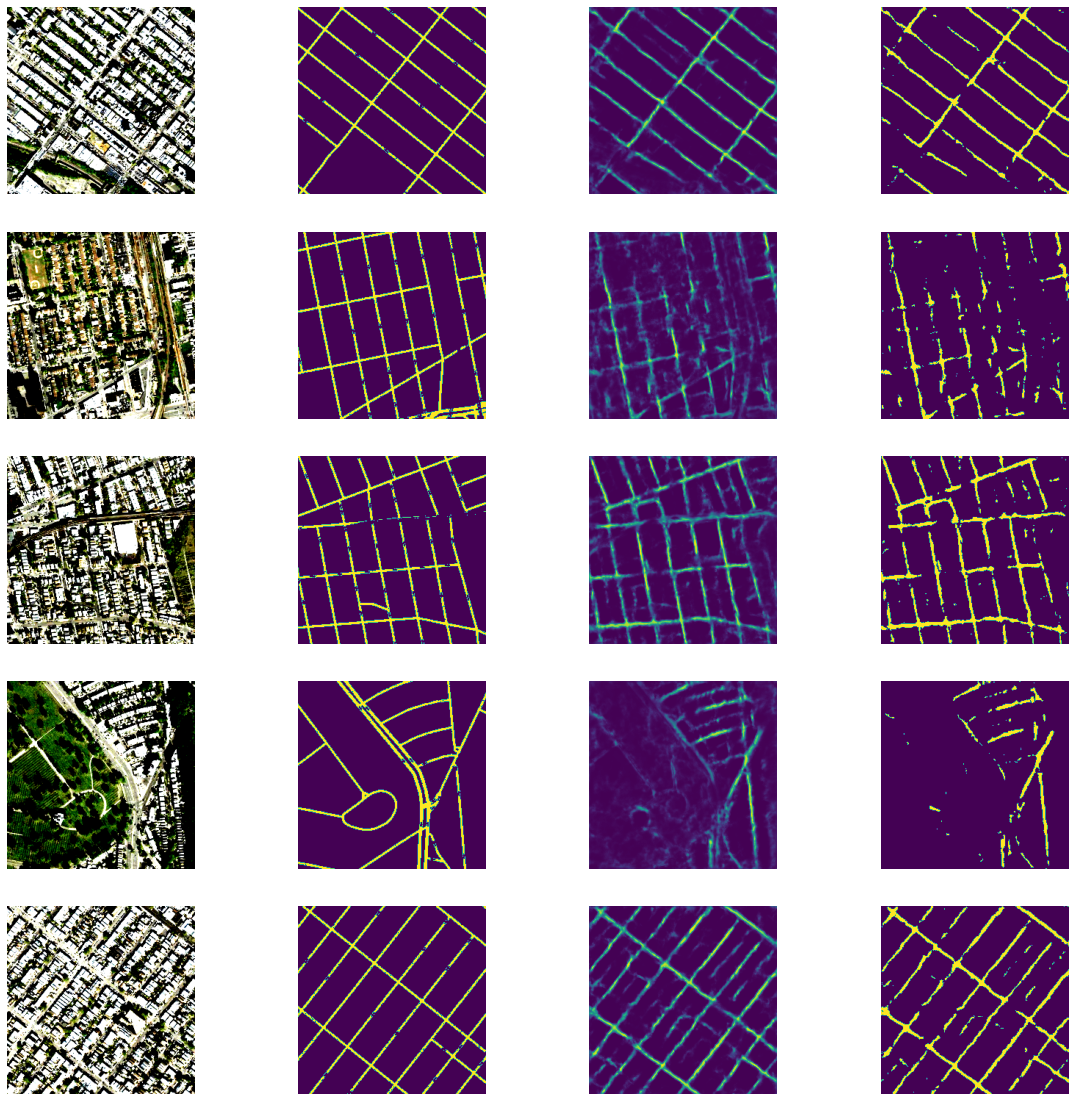

In [ ]:
plt.figure(figsize=(20,20))
for i in range(5):
  # Plotting the input image
  plt.subplot(5, 4, i*4+1)
  plt.imshow(imgs_test[i,:,:,:],vmin=0,vmax=255)
  plt.axis('off')
  # Plotting the input labels
  plt.subplot(5, 4, i*4+2)
  plt.imshow(imgs_mask_test[i,:,:,0],vmin=0,vmax=1)
  plt.axis('off')
  # Plotting the output classifier
  plt.subplot(5, 4, i*4+3)
  plt.imshow(out_mask_test[i,:,:,0])
  plt.axis('off')
  # Plotting the output rescaled by thresholding output
  plt.subplot(5, 4, i*4+4)
  plt.imshow(out_mask_test[i,:,:,0]>0.3)
  plt.axis('off')
  
  

## Question 4: Applying and understanding U-Nets

Apply the U-Net architecture to the entire training set and increase the learning time (epochs) to improve performance.

Plot the model performance for both the training and testing.

Plot the input image and label vs. the U-Net trained label and identify discuss the performance. Identify cases where the model performs poorly and well, respectively, at identifying the roads. Explain why this is the case.

# Acknowledgements
Created by Stef Lhermitte (s.lhermitte at tudelft.nl / @steflhermitte | www.earthmapps.io) with a lot of inspiration from:

 * [Stanfords CS231n course](https://cs231n.github.io/convolutional-networks/)
 * [Transfer learning with Keras](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/)
